In [1]:
## Setup

In [2]:
"""
JUPYTER NOTEBOOK - CELL 1
Setup and Imports
"""

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Utilities
import warnings
from datetime import datetime

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("="*80)
print("PURCHASE INVOICE ANALYSIS - AINextBill Technology")
print("Data Science Intern Assignment")
print("="*80)
print("\nAll libraries imported successfully")
print("Environment configured")

PURCHASE INVOICE ANALYSIS - AINextBill Technology
Data Science Intern Assignment

All libraries imported successfully
Environment configured


In [3]:
## Load Data

In [4]:
"""
JUPYTER NOTEBOOK - CELL 2
Load and Explore Raw Data
"""

# Load the dataset
file_path = 'purchase_invoices_dataset.xlsx'
df = pd.read_excel(file_path)

# Keep original copy for comparison
df_original = df.copy()

print("="*80)
print("DATA LOADING AND INITIAL EXPLORATION")
print("="*80)

# Basic information
print(f"\nDataset Shape: {df.shape[0]} rows x {df.shape[1]} columns")
print(f"\nDate Range: {df['invoice_date'].min()} to {df['invoice_date'].max()}")

print("\n" + "-"*80)
print("COLUMN INFORMATION")
print("-"*80)
print(df.dtypes)

print("\n" + "-"*80)
print("MISSING VALUES")
print("-"*80)
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("No missing values detected")

print("\n" + "-"*80)
print("FIRST 10 RECORDS")
print("-"*80)
print(df.head(10))

print("\n" + "-"*80)
print("NUMERICAL STATISTICS")
print("-"*80)
print(df.describe())

print("\n" + "-"*80)
print("CATEGORICAL DISTRIBUTIONS")
print("-"*80)
print(f"\nUnique Vendors: {df['vendor_name'].nunique()}")
print(f"Unique Categories: {df['expense_category'].nunique()}")
print(f"GST Rates: {sorted(df['gst_rate'].unique())}")
print(f"Payment Modes: {df['payment_mode'].unique().tolist()}")

FileNotFoundError: [Errno 2] No such file or directory: 'purchase_invoices_dataset.xlsx'

In [ ]:
"""
JUPYTER NOTEBOOK - CELL 3
Data Quality Assessment
"""

print("="*80)
print("DATA QUALITY ANALYSIS")
print("="*80)

# Issue 1: Expense Category Inconsistencies
print("\n" + "-"*80)
print("ISSUE 1: EXPENSE CATEGORY VARIATIONS")
print("-"*80)
print("\nOriginal category distribution:")
category_counts = df['expense_category'].value_counts()
print(category_counts)

print(f"\nTotal unique categories: {df['expense_category'].nunique()}")
print("\nIdentified variants:")
print("  - 'Raw Material', 'raw material', 'Raw Materials', 'RawMaterial'")
print("  - 'Software', 'software', 'SW', 'Software License'")
print("  - 'Office Supplies', 'office supplies'")

# Issue 2: Missing GST Amounts
print("\n" + "-"*80)
print("ISSUE 2: MISSING GST AMOUNTS")
print("-"*80)
missing_gst = df[df['gst_amount'].isnull()]
if len(missing_gst) > 0:
    print(f"\nFound {len(missing_gst)} records with missing GST amounts:")
    print(missing_gst[['invoice_id', 'vendor_name', 'invoice_amount', 
                        'gst_rate', 'gst_amount']])
    total_missing = (missing_gst['invoice_amount'] * 
                     missing_gst['gst_rate'] / 100).sum()
    print(f"\nPotential tax credit at risk: Rs. {total_missing:,.2f}")
else:
    print("No missing GST amounts")

# Issue 3: Date Format
print("\n" + "-"*80)
print("ISSUE 3: DATE FORMAT")
print("-"*80)
print(f"Current data type: {df['invoice_date'].dtype}")
print(f"Sample values: {df['invoice_date'].head(3).tolist()}")
print("Issue: Stored as text, needs conversion to datetime")

# Issue 4: GST Calculation Validation
print("\n" + "-"*80)
print("ISSUE 4: GST CALCULATION ACCURACY")
print("-"*80)
df_check = df[df['gst_amount'].notna()].copy()
df_check['calculated_gst'] = (df_check['invoice_amount'] * 
                                df_check['gst_rate'] / 100).round(2)
df_check['gst_difference'] = abs(df_check['gst_amount'] - 
                                  df_check['calculated_gst'])

mismatches = df_check[df_check['gst_difference'] > 0.5]
print(f"Records with GST calculation mismatch (>Rs. 0.5): {len(mismatches)}")
if len(mismatches) > 0:
    print("\nAffected invoices:")
    print(mismatches[['invoice_id', 'vendor_name', 'invoice_amount', 
                       'gst_rate', 'gst_amount', 'calculated_gst', 
                       'gst_difference']].head())

print("\n" + "-"*80)
print("SUMMARY: Data Quality Issues Identified")
print("-"*80)
print(f"1. Category inconsistencies: {df['expense_category'].nunique()} variants found")
print(f"2. Missing GST amounts: {len(missing_gst)} records")
print(f"3. Date format: Needs conversion from string to datetime")
print(f"4. GST calculation errors: {len(mismatches)} records")
print(f"\nTotal issues to address: {len(missing_gst) + len(mismatches)}")

DATA QUALITY ANALYSIS

--------------------------------------------------------------------------------
ISSUE 1: EXPENSE CATEGORY VARIATIONS
--------------------------------------------------------------------------------

Original category distribution:
expense_category
Raw Material        528
Software            464
Travel              150
Utilities            96
Maintenance          88
Office Supplies      71
Marketing            67
SW                    7
Raw Materials         7
raw material          7
software              5
Software License      5
RawMaterial           3
office supplies       2
Name: count, dtype: int64

Total unique categories: 14

Identified variants:
  - 'Raw Material', 'raw material', 'Raw Materials', 'RawMaterial'
  - 'Software', 'software', 'SW', 'Software License'
  - 'Office Supplies', 'office supplies'

--------------------------------------------------------------------------------
ISSUE 2: MISSING GST AMOUNTS
-------------------------------------------

In [ ]:
"""
JUPYTER NOTEBOOK - CELL 4
Data Cleaning and Standardization
"""

print("="*80)
print("DATA CLEANING PROCESS")
print("="*80)

# Step 1: Standardize Expense Categories
print("\n" + "-"*80)
print("STEP 1: STANDARDIZING EXPENSE CATEGORIES")
print("-"*80)

# Create temporary lowercase column
df['category_temp'] = df['expense_category'].str.strip().str.lower()

# Define mapping
category_mapping = {
    'raw material': 'Raw Material',
    'raw materials': 'Raw Material',
    'rawmaterial': 'Raw Material',
    'software': 'Software',
    'sw': 'Software',
    'software license': 'Software',
    'office supplies': 'Office Supplies'
}

# Apply mapping
for variant, standard in category_mapping.items():
    df.loc[df['category_temp'] == variant, 'expense_category'] = standard

# Clean up temporary column
df.drop('category_temp', axis=1, inplace=True)

print("Standardized category distribution:")
print(df['expense_category'].value_counts())
print(f"\nCategories reduced: {df_original['expense_category'].nunique()} -> {df['expense_category'].nunique()}")

# Step 2: Fix Missing GST Amounts
print("\n" + "-"*80)
print("STEP 2: IMPUTING MISSING GST AMOUNTS")
print("-"*80)

missing_gst_mask = df['gst_amount'].isnull()
missing_count = missing_gst_mask.sum()

if missing_count > 0:
    print(f"Imputing {missing_count} missing GST amounts...")
    
    # Calculate missing GST
    df.loc[missing_gst_mask, 'gst_amount'] = (
        df.loc[missing_gst_mask, 'invoice_amount'] * 
        df.loc[missing_gst_mask, 'gst_rate'] / 100
    ).round(2)
    
    # Create flag for imputed values
    df['gst_amount_imputed'] = missing_gst_mask
    
    total_imputed = df[missing_gst_mask]['gst_amount'].sum()
    print(f"Total GST imputed: Rs. {total_imputed:,.2f}")
    print("Created flag column: gst_amount_imputed")
else:
    df['gst_amount_imputed'] = False
    print("No missing GST amounts to impute")

# Step 3: Parse and Validate Dates
print("\n" + "-"*80)
print("STEP 3: PARSING DATES")
print("-"*80)

# Convert to datetime
df['invoice_date'] = pd.to_datetime(df['invoice_date'], errors='coerce')

# Extract time components
df['invoice_month'] = df['invoice_date'].dt.to_period('M')
df['invoice_year'] = df['invoice_date'].dt.year
df['invoice_quarter'] = df['invoice_date'].dt.to_period('Q')
df['day_of_week'] = df['invoice_date'].dt.day_name()
df['day_of_month'] = df['invoice_date'].dt.day

parsing_failures = df['invoice_date'].isnull().sum()
print(f"Dates parsed successfully: {len(df) - parsing_failures}")
print(f"Parsing failures: {parsing_failures}")
print(f"\nDate range: {df['invoice_date'].min()} to {df['invoice_date'].max()}")
print(f"Time span: {(df['invoice_date'].max() - df['invoice_date'].min()).days} days")

# Step 4: Validate GST Calculations
print("\n" + "-"*80)
print("STEP 4: VALIDATING GST CALCULATIONS")
print("-"*80)

df['gst_calculated'] = (df['invoice_amount'] * df['gst_rate'] / 100).round(2)
df['gst_variance'] = abs(df['gst_amount'] - df['gst_calculated'])
df['gst_error_flag'] = df['gst_variance'] > 0.50

error_count = df['gst_error_flag'].sum()
print(f"GST calculation errors found: {error_count}")
if error_count > 0:
    print("\nRecords flagged for review:")
    print(df[df['gst_error_flag']][['invoice_id', 'vendor_name', 
                                      'gst_amount', 'gst_calculated', 
                                      'gst_variance']].head())

print("\n" + "-"*80)
print("DATA CLEANING COMPLETED")
print("-"*80)
print(f"Records processed: {len(df)}")
print(f"Columns after cleaning: {len(df.columns)}")
print(f"Data quality issues resolved: {missing_count + error_count}")

DATA CLEANING PROCESS

--------------------------------------------------------------------------------
STEP 1: STANDARDIZING EXPENSE CATEGORIES
--------------------------------------------------------------------------------
Standardized category distribution:
expense_category
Raw Material       545
Software           481
Travel             150
Utilities           96
Maintenance         88
Office Supplies     73
Marketing           67
Name: count, dtype: int64

Categories reduced: 14 -> 7

--------------------------------------------------------------------------------
STEP 2: IMPUTING MISSING GST AMOUNTS
--------------------------------------------------------------------------------
Imputing 4 missing GST amounts...
Total GST imputed: Rs. 190,833.17
Created flag column: gst_amount_imputed

--------------------------------------------------------------------------------
STEP 3: PARSING DATES
--------------------------------------------------------------------------------
Dates parsed

In [ ]:
"""
JUPYTER NOTEBOOK - CELL 5
Feature Engineering
"""

print("="*80)
print("FEATURE ENGINEERING")
print("="*80)

# Feature 1: Expense without GST (base amount)
df['expense_without_gst'] = df['invoice_amount']
print("\n[1/7] Created: expense_without_gst")
print("      Purpose: True expense amount (GST is recoverable via ITC)")

# Feature 2: Effective GST Rate
df['gst_effective_rate'] = np.where(
    df['invoice_amount'] > 0,
    (df['gst_amount'] / df['invoice_amount'] * 100).round(2),
    0
)
print("\n[2/7] Created: gst_effective_rate")
print("      Purpose: Actual GST percentage paid (handles edge cases)")

# Feature 3: High-value transaction flag
threshold_90 = df['invoice_amount'].quantile(0.90)
df['high_value_flag'] = df['invoice_amount'] > threshold_90
high_value_count = df['high_value_flag'].sum()
print(f"\n[3/7] Created: high_value_flag")
print(f"      Threshold: Rs. {threshold_90:,.2f} (90th percentile)")
print(f"      High-value invoices: {high_value_count}")

# Feature 4: Vendor invoice count
vendor_counts = df.groupby('vendor_name').size()
df['vendor_invoice_count'] = df['vendor_name'].map(vendor_counts)
print("\n[4/7] Created: vendor_invoice_count")
print("      Purpose: Frequency of vendor transactions")

# Feature 5: Vendor months active
vendor_month_counts = df.groupby('vendor_name')['invoice_month'].nunique()
df['vendor_months_active'] = df['vendor_name'].map(vendor_month_counts)
print("\n[5/7] Created: vendor_months_active")
print("      Purpose: Vendor consistency metric")

# Feature 6: Cumulative spend by category
df = df.sort_values('invoice_date')
df['category_cumulative_spend'] = df.groupby('expense_category')['invoice_amount'].cumsum()
print("\n[6/7] Created: category_cumulative_spend")
print("      Purpose: Track expense trends over time")

# Feature 7: Days since last vendor invoice
df['days_since_last_invoice'] = df.groupby('vendor_name')['invoice_date'].diff().dt.days
print("\n[7/7] Created: days_since_last_invoice")
print("      Purpose: Payment cycle and vendor activity analysis")

print("\n" + "-"*80)
print("FEATURE ENGINEERING SUMMARY")
print("-"*80)
print(f"Original columns: {len(df_original.columns)}")
print(f"New columns added: {len(df.columns) - len(df_original.columns)}")
print(f"Total columns: {len(df.columns)}")

print("\n" + "-"*80)
print("SAMPLE OF ENGINEERED FEATURES")
print("-"*80)
print(df[['invoice_id', 'expense_without_gst', 'gst_effective_rate', 
          'high_value_flag', 'vendor_invoice_count']].head(10))

print("\n" + "-"*80)
print("FEATURE STATISTICS")
print("-"*80)
feature_stats = df[['expense_without_gst', 'gst_effective_rate', 
                     'vendor_invoice_count', 'vendor_months_active']].describe()
print(feature_stats)

FEATURE ENGINEERING

[1/7] Created: expense_without_gst
      Purpose: True expense amount (GST is recoverable via ITC)

[2/7] Created: gst_effective_rate
      Purpose: Actual GST percentage paid (handles edge cases)

[3/7] Created: high_value_flag
      Threshold: Rs. 885,749.37 (90th percentile)
      High-value invoices: 150

[4/7] Created: vendor_invoice_count
      Purpose: Frequency of vendor transactions

[5/7] Created: vendor_months_active
      Purpose: Vendor consistency metric

[6/7] Created: category_cumulative_spend
      Purpose: Track expense trends over time

[7/7] Created: days_since_last_invoice
      Purpose: Payment cycle and vendor activity analysis

--------------------------------------------------------------------------------
FEATURE ENGINEERING SUMMARY
--------------------------------------------------------------------------------
Original columns: 10
New columns added: 16
Total columns: 26

-------------------------------------------------------------------

MONTHLY EXPENSE TREND ANALYSIS

--------------------------------------------------------------------------------
MONTHLY TRENDS TABLE
--------------------------------------------------------------------------------
   invoice_month  total_spend  invoice_count  unique_vendors  mom_growth_pct
0        2024-02  18681984.99             67              17             NaN
1        2024-03  27529087.63             57              17           47.36
2        2024-04  22496199.76             59              13          -18.28
3        2024-05  18682161.91             61              16          -16.95
4        2024-06   8700181.33             55              18          -53.43
5        2024-07  14532405.33             74              20           67.04
6        2024-08  14246949.30             64              16           -1.96
7        2024-09  29795517.28             56              19          109.14
8        2024-10  37320561.84             58              16           25.26
9        2024-1

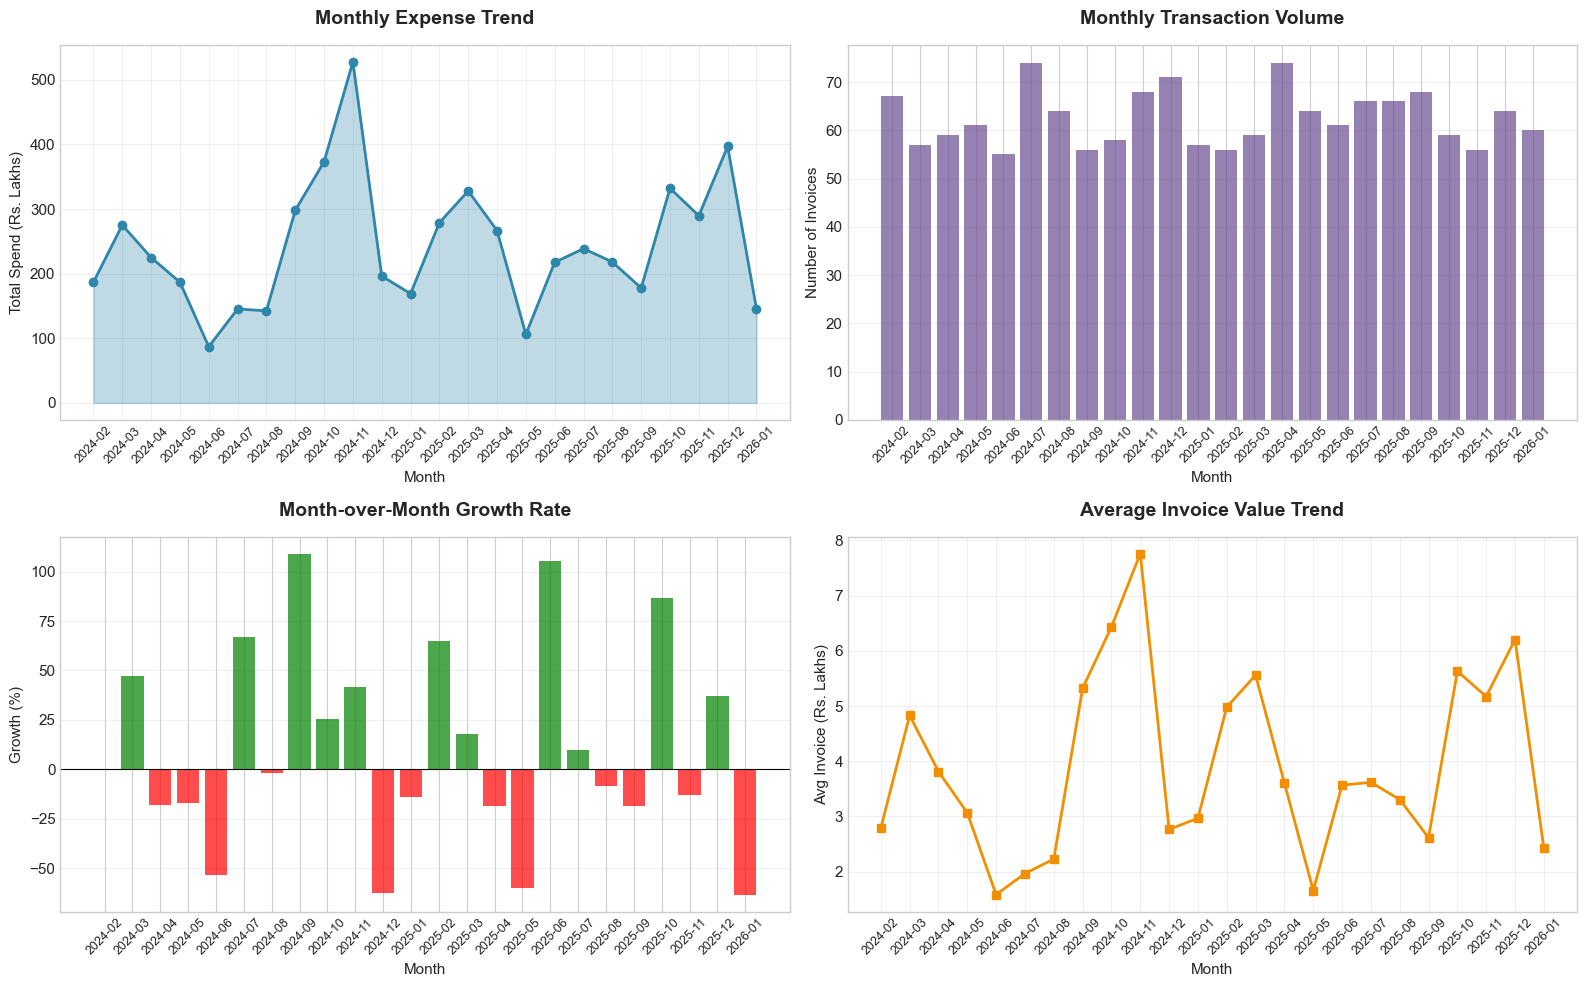


Monthly trend analysis complete


In [ ]:
"""
JUPYTER NOTEBOOK - CELL 6
Monthly Expense Trend Analysis
"""

print("="*80)
print("MONTHLY EXPENSE TREND ANALYSIS")
print("="*80)

# Aggregate by month
monthly_trends = df.groupby('invoice_month').agg({
    'invoice_amount': ['sum', 'mean', 'std'],
    'gst_amount': 'sum',
    'total_amount': 'sum',
    'invoice_id': 'count',
    'vendor_name': 'nunique',
    'expense_category': 'nunique'
}).round(2)

# Flatten column names
monthly_trends.columns = [
    'total_spend', 'avg_invoice', 'spend_volatility',
    'total_gst', 'total_payable', 'invoice_count',
    'unique_vendors', 'unique_categories'
]

# Calculate month-over-month growth
monthly_trends['mom_growth_pct'] = (
    monthly_trends['total_spend'].pct_change() * 100
).round(2)

# Reset index
monthly_trends = monthly_trends.reset_index()
monthly_trends['invoice_month'] = monthly_trends['invoice_month'].astype(str)

print("\n" + "-"*80)
print("MONTHLY TRENDS TABLE")
print("-"*80)
print(monthly_trends[['invoice_month', 'total_spend', 'invoice_count', 
                       'unique_vendors', 'mom_growth_pct']])

print("\n" + "-"*80)
print("SUMMARY STATISTICS")
print("-"*80)
print(f"Total months analyzed: {len(monthly_trends)}")
print(f"Average monthly spend: Rs. {monthly_trends['total_spend'].mean():,.2f}")
print(f"Highest spending month: {monthly_trends.loc[monthly_trends['total_spend'].idxmax(), 'invoice_month']}")
print(f"  Amount: Rs. {monthly_trends['total_spend'].max():,.2f}")
print(f"Lowest spending month: {monthly_trends.loc[monthly_trends['total_spend'].idxmin(), 'invoice_month']}")
print(f"  Amount: Rs. {monthly_trends['total_spend'].min():,.2f}")
print(f"Average MoM growth: {monthly_trends['mom_growth_pct'].abs().mean():.2f}%")

# Identify volatile months
volatile_months = monthly_trends[monthly_trends['mom_growth_pct'].abs() > 20]
if len(volatile_months) > 0:
    print(f"\n" + "-"*80)
    print("VOLATILE MONTHS (>20% change)")
    print("-"*80)
    print(volatile_months[['invoice_month', 'total_spend', 'mom_growth_pct']])

# Visualization
print("\n" + "-"*80)
print("GENERATING MONTHLY TREND VISUALIZATION")
print("-"*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Monthly Spending Trend
ax1 = axes[0, 0]
months = monthly_trends['invoice_month'].values
spend = monthly_trends['total_spend'].values / 100000  # In lakhs

ax1.plot(months, spend, marker='o', linewidth=2, markersize=6, color='#2E86AB')
ax1.fill_between(range(len(months)), spend, alpha=0.3, color='#2E86AB')
ax1.set_title('Monthly Expense Trend', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Month', fontsize=11)
ax1.set_ylabel('Total Spend (Rs. Lakhs)', fontsize=11)
ax1.tick_params(axis='x', rotation=45, labelsize=9)
ax1.grid(True, alpha=0.3)

# Plot 2: Transaction Volume
ax2 = axes[0, 1]
ax2.bar(range(len(months)), monthly_trends['invoice_count'].values, 
        color='#6A4C93', alpha=0.7)
ax2.set_title('Monthly Transaction Volume', fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('Month', fontsize=11)
ax2.set_ylabel('Number of Invoices', fontsize=11)
ax2.set_xticks(range(len(months)))
ax2.set_xticklabels(months, rotation=45, fontsize=9)
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Month-over-Month Growth
ax3 = axes[1, 0]
colors = ['green' if x > 0 else 'red' for x in monthly_trends['mom_growth_pct'].fillna(0)]
ax3.bar(range(len(months)), monthly_trends['mom_growth_pct'].fillna(0), 
        color=colors, alpha=0.7)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax3.set_title('Month-over-Month Growth Rate', fontsize=14, fontweight='bold', pad=15)
ax3.set_xlabel('Month', fontsize=11)
ax3.set_ylabel('Growth (%)', fontsize=11)
ax3.set_xticks(range(len(months)))
ax3.set_xticklabels(months, rotation=45, fontsize=9)
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Average Invoice Value
ax4 = axes[1, 1]
avg_invoice = monthly_trends['total_spend'] / monthly_trends['invoice_count'] / 100000
ax4.plot(range(len(months)), avg_invoice, marker='s', linewidth=2, 
         markersize=6, color='#F18F01')
ax4.set_title('Average Invoice Value Trend', fontsize=14, fontweight='bold', pad=15)
ax4.set_xlabel('Month', fontsize=11)
ax4.set_ylabel('Avg Invoice (Rs. Lakhs)', fontsize=11)
ax4.set_xticks(range(len(months)))
ax4.set_xticklabels(months, rotation=45, fontsize=9)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/monthly_trends_visualization.png', 
            dpi=300, bbox_inches='tight')
print("Saved: monthly_trends_visualization.png")
plt.show()

print("\nMonthly trend analysis complete")

EXPENSE CATEGORY ANALYSIS

--------------------------------------------------------------------------------
CATEGORY BREAKDOWN TABLE
--------------------------------------------------------------------------------
                  total_spend  invoice_count  pct_of_total  \
expense_category                                             
Raw Material     349193432.77            545         60.11   
Software         190562170.73            481         32.81   
Travel            14080450.78            150          2.42   
Utilities         10089928.32             96          1.74   
Maintenance        8699730.27             88          1.50   
Marketing          7345941.21             67          1.26   
Office Supplies     915783.89             73          0.16   

                  coefficient_of_variation volatility_type  
expense_category                                            
Raw Material                         62.53        Volatile  
Software                             73.46  

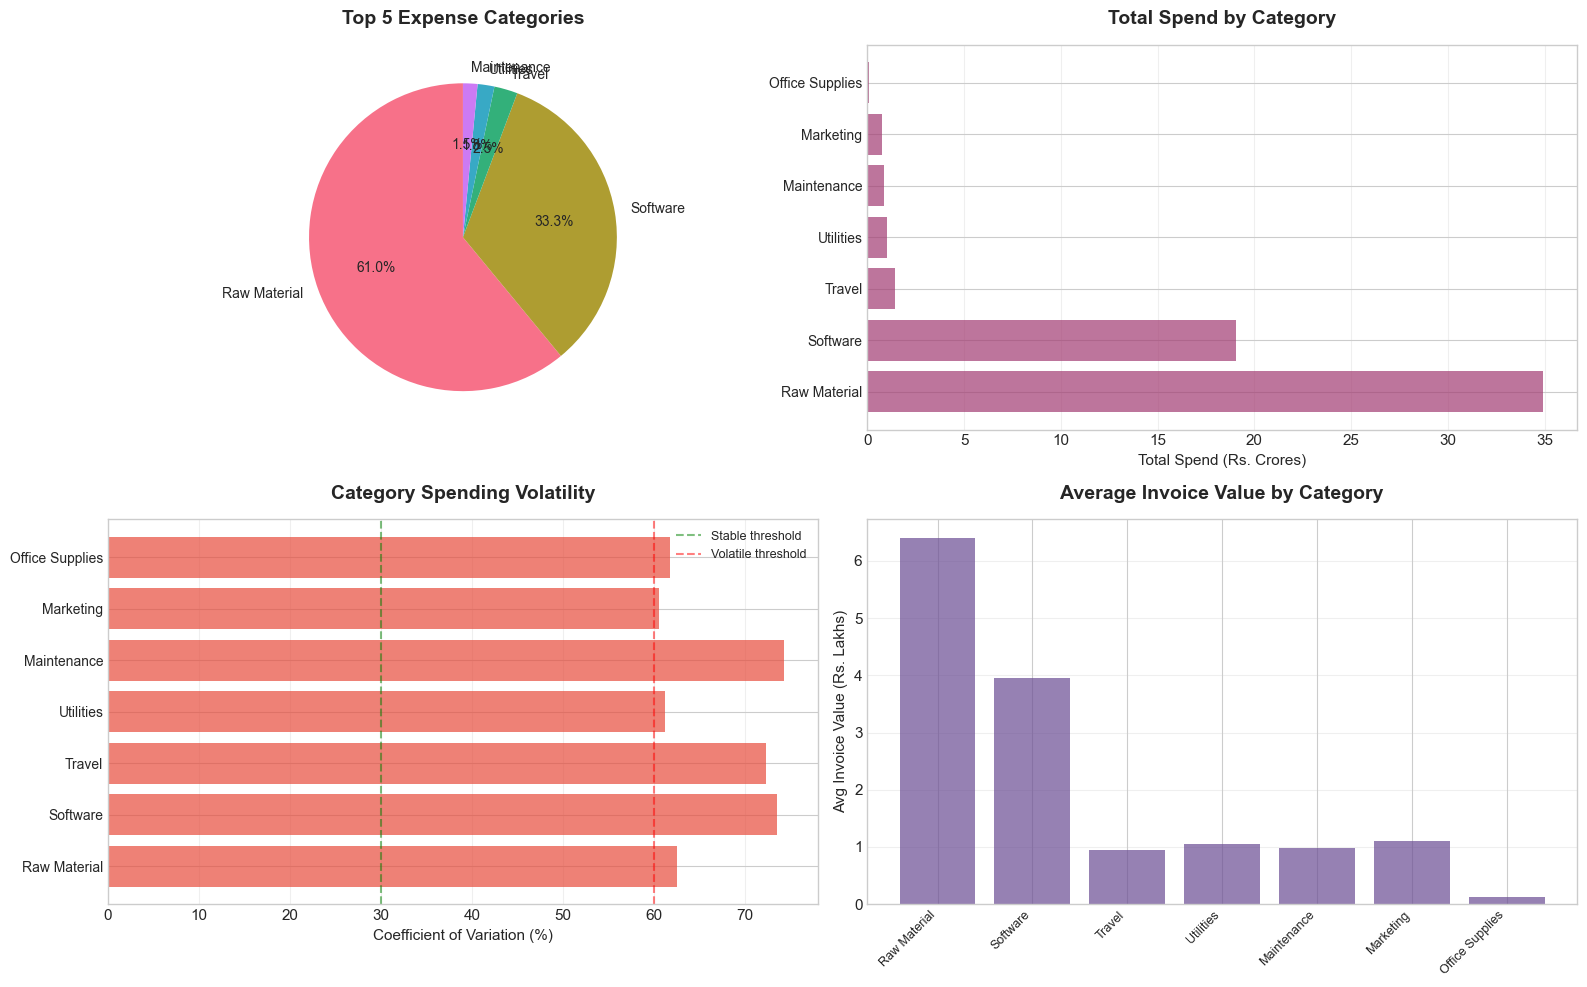


Category analysis complete


In [ ]:
"""
JUPYTER NOTEBOOK - CELL 7
Expense Category Analysis
"""

print("="*80)
print("EXPENSE CATEGORY ANALYSIS")
print("="*80)

# Aggregate by category
category_analysis = df.groupby('expense_category').agg({
    'invoice_amount': ['sum', 'mean', 'std', 'count', 'min', 'max'],
    'gst_amount': 'sum',
    'vendor_name': 'nunique'
}).round(2)

# Flatten columns
category_analysis.columns = [
    'total_spend', 'avg_invoice', 'std_dev', 'invoice_count',
    'min_invoice', 'max_invoice', 'total_gst', 'unique_vendors'
]

# Calculate coefficient of variation (volatility metric)
category_analysis['coefficient_of_variation'] = (
    category_analysis['std_dev'] / category_analysis['avg_invoice'] * 100
).round(2)

# Classify volatility
def classify_volatility(cv):
    if cv < 30:
        return 'Stable'
    elif cv < 60:
        return 'Moderate'
    else:
        return 'Volatile'

category_analysis['volatility_type'] = \
    category_analysis['coefficient_of_variation'].apply(classify_volatility)

# Calculate percentage of total spend
total_spend = category_analysis['total_spend'].sum()
category_analysis['pct_of_total'] = (
    category_analysis['total_spend'] / total_spend * 100
).round(2)

# Sort by total spend
category_analysis = category_analysis.sort_values('total_spend', ascending=False)

print("\n" + "-"*80)
print("CATEGORY BREAKDOWN TABLE")
print("-"*80)
print(category_analysis[['total_spend', 'invoice_count', 'pct_of_total', 
                          'coefficient_of_variation', 'volatility_type']])

print("\n" + "-"*80)
print("TOP 3 EXPENSE CATEGORIES")
print("-"*80)
for i, (cat, row) in enumerate(category_analysis.head(3).iterrows(), 1):
    print(f"\n{i}. {cat}")
    print(f"   Total Spend: Rs. {row['total_spend']:,.2f}")
    print(f"   Invoice Count: {row['invoice_count']:.0f}")
    print(f"   Percentage of Total: {row['pct_of_total']:.1f}%")
    print(f"   Avg Invoice Value: Rs. {row['avg_invoice']:,.2f}")
    print(f"   Volatility: {row['volatility_type']} (CV: {row['coefficient_of_variation']:.1f}%)")

# Stable vs Volatile Analysis
print("\n" + "-"*80)
print("VOLATILITY CLASSIFICATION")
print("-"*80)

stable = category_analysis[category_analysis['volatility_type'] == 'Stable']
moderate = category_analysis[category_analysis['volatility_type'] == 'Moderate']
volatile = category_analysis[category_analysis['volatility_type'] == 'Volatile']

print(f"\nStable Categories ({len(stable)}):")
print("  Characteristic: Predictable, likely recurring subscriptions/contracts")
for cat in stable.index:
    print(f"  - {cat}: Rs. {stable.loc[cat, 'total_spend']:,.2f}")

print(f"\nModerate Categories ({len(moderate)}):")
print("  Characteristic: Some variability, project-based or seasonal")
for cat in moderate.index:
    print(f"  - {cat}: Rs. {moderate.loc[cat, 'total_spend']:,.2f}")

print(f"\nVolatile Categories ({len(volatile)}):")
print("  Characteristic: Highly irregular, commodity-driven or ad-hoc")
for cat in volatile.index:
    print(f"  - {cat}: Rs. {volatile.loc[cat, 'total_spend']:,.2f}")

# Visualization
print("\n" + "-"*80)
print("GENERATING CATEGORY VISUALIZATIONS")
print("-"*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Spending Distribution (Pie Chart)
ax1 = axes[0, 0]
top_categories = category_analysis.head(5)
colors = sns.color_palette("husl", len(top_categories))
wedges, texts, autotexts = ax1.pie(
    top_categories['total_spend'],
    labels=top_categories.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 10}
)
ax1.set_title('Top 5 Expense Categories', fontsize=14, fontweight='bold', pad=15)

# Plot 2: Spending by Category (Bar Chart)
ax2 = axes[0, 1]
categories = category_analysis.index
spend_values = category_analysis['total_spend'].values / 10000000  # In crores
ax2.barh(range(len(categories)), spend_values, color='#A23B72', alpha=0.7)
ax2.set_yticks(range(len(categories)))
ax2.set_yticklabels(categories, fontsize=10)
ax2.set_xlabel('Total Spend (Rs. Crores)', fontsize=11)
ax2.set_title('Total Spend by Category', fontsize=14, fontweight='bold', pad=15)
ax2.grid(axis='x', alpha=0.3)

# Plot 3: Category Volatility
ax3 = axes[1, 0]
cv_values = category_analysis['coefficient_of_variation'].values
colors_volatility = ['#27AE60' if x < 30 else '#F39C12' if x < 60 else '#E74C3C' 
                     for x in cv_values]
ax3.barh(range(len(categories)), cv_values, color=colors_volatility, alpha=0.7)
ax3.set_yticks(range(len(categories)))
ax3.set_yticklabels(categories, fontsize=10)
ax3.set_xlabel('Coefficient of Variation (%)', fontsize=11)
ax3.set_title('Category Spending Volatility', fontsize=14, fontweight='bold', pad=15)
ax3.axvline(x=30, color='green', linestyle='--', alpha=0.5, label='Stable threshold')
ax3.axvline(x=60, color='red', linestyle='--', alpha=0.5, label='Volatile threshold')
ax3.legend(fontsize=9)
ax3.grid(axis='x', alpha=0.3)

# Plot 4: Average Invoice Value by Category
ax4 = axes[1, 1]
avg_values = category_analysis['avg_invoice'].values / 100000  # In lakhs
ax4.bar(range(len(categories)), avg_values, color='#6A4C93', alpha=0.7)
ax4.set_xticks(range(len(categories)))
ax4.set_xticklabels(categories, rotation=45, ha='right', fontsize=9)
ax4.set_ylabel('Avg Invoice Value (Rs. Lakhs)', fontsize=11)
ax4.set_title('Average Invoice Value by Category', fontsize=14, fontweight='bold', pad=15)
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/category_analysis_visualization.png', 
            dpi=300, bbox_inches='tight')
print("Saved: category_analysis_visualization.png")
plt.show()

print("\nCategory analysis complete")

VENDOR PATTERN ANALYSIS

--------------------------------------------------------------------------------
TOP 10 VENDORS BY SPEND
--------------------------------------------------------------------------------
                              total_spend  invoice_count  months_active  \
vendor_name                                                               
Tata Steel Limited           176905485.42            204             24   
JSW Materials Pvt Ltd        117833966.79            208             24   
SAP India Systems             85659581.25            155             24   
Microsoft India Pvt Ltd       81384590.17            167             24   
Reliance Industrial Supplies  54453980.56            133             24   
Amazon Web Services India     12989229.85             79             24   
Mahindra Logistics Ltd        12031131.17            100             23   
Google Cloud India             9938403.11             63             22   
BPCL Fuel Services             8562809.

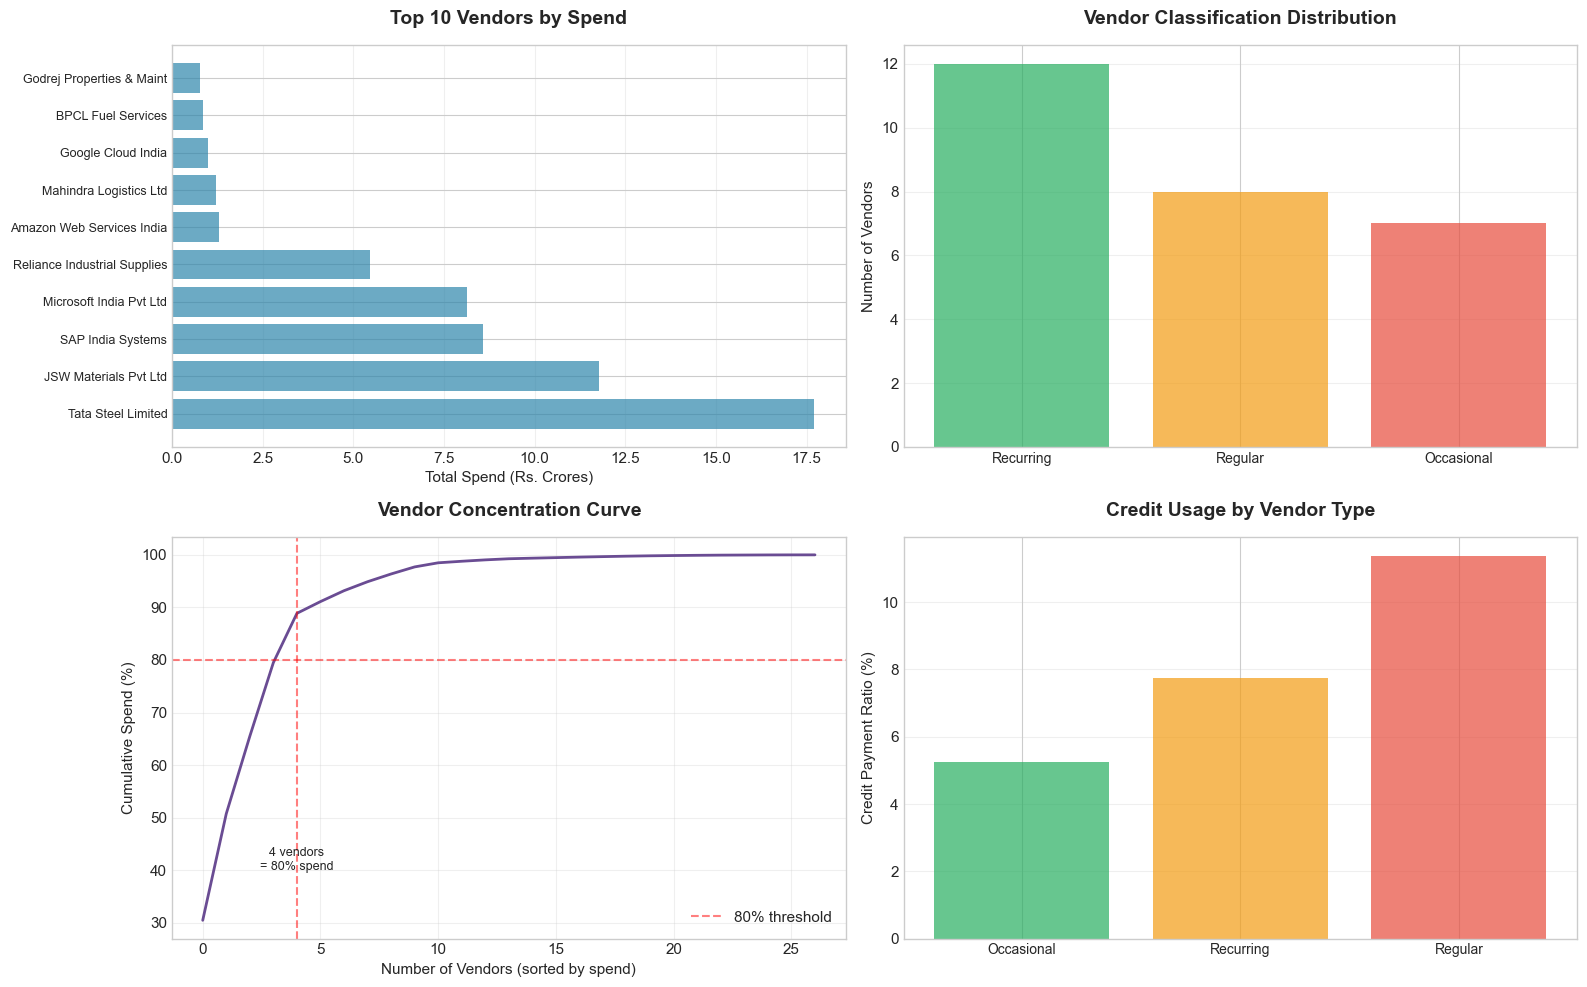


Key Finding: 4 vendors (out of 27) account for 80% of total spend
Vendor analysis complete


In [ ]:
"""
JUPYTER NOTEBOOK - CELL 8
Vendor Pattern Analysis
"""

print("="*80)
print("VENDOR PATTERN ANALYSIS")
print("="*80)

# Calculate total months
total_months = df['invoice_month'].nunique()

# Aggregate by vendor
vendor_analysis = df.groupby('vendor_name').agg({
    'invoice_amount': ['sum', 'mean', 'count'],
    'invoice_month': 'nunique',
    'gst_amount': 'sum',
    'payment_mode': lambda x: (x == 'Credit').sum() / len(x) * 100
}).round(2)

# Flatten columns
vendor_analysis.columns = [
    'total_spend', 'avg_invoice', 'invoice_count',
    'months_active', 'total_gst', 'credit_payment_pct'
]

# Calculate additional metrics
vendor_analysis['monthly_avg_spend'] = (
    vendor_analysis['total_spend'] / vendor_analysis['months_active']
).round(2)

vendor_analysis['months_active_pct'] = (
    vendor_analysis['months_active'] / total_months * 100
).round(2)

# Classify vendors
def classify_vendor(pct):
    if pct > 75:
        return 'Recurring'
    elif pct > 40:
        return 'Regular'
    else:
        return 'Occasional'

vendor_analysis['vendor_type'] = \
    vendor_analysis['months_active_pct'].apply(classify_vendor)

# Sort by total spend
vendor_analysis = vendor_analysis.sort_values('total_spend', ascending=False)

print("\n" + "-"*80)
print("TOP 10 VENDORS BY SPEND")
print("-"*80)
print(vendor_analysis[['total_spend', 'invoice_count', 'months_active', 
                        'vendor_type', 'credit_payment_pct']].head(10))

print("\n" + "-"*80)
print("VENDOR SUMMARY STATISTICS")
print("-"*80)
print(f"Total unique vendors: {len(vendor_analysis)}")
print(f"Average spend per vendor: Rs. {vendor_analysis['total_spend'].mean():,.2f}")
print(f"Median spend per vendor: Rs. {vendor_analysis['total_spend'].median():,.2f}")
print(f"Top vendor: {vendor_analysis.index[0]}")
print(f"  Total spend: Rs. {vendor_analysis.iloc[0]['total_spend']:,.2f}")
print(f"  Invoice count: {vendor_analysis.iloc[0]['invoice_count']:.0f}")

# Vendor concentration analysis
top3_spend = vendor_analysis.head(3)['total_spend'].sum()
total_spend = vendor_analysis['total_spend'].sum()
concentration_pct = (top3_spend / total_spend * 100)

print(f"\n" + "-"*80)
print("VENDOR CONCENTRATION RISK")
print("-"*80)
print(f"Top 3 vendors account for: {concentration_pct:.1f}% of total spend")
if concentration_pct > 50:
    print("WARNING: High vendor concentration risk detected")
    print("Recommendation: Consider diversifying vendor base")

# Vendor type distribution
print("\n" + "-"*80)
print("VENDOR CLASSIFICATION")
print("-"*80)

vendor_types = vendor_analysis['vendor_type'].value_counts()
for vtype in ['Recurring', 'Regular', 'Occasional']:
    if vtype in vendor_types.index:
        count = vendor_types[vtype]
        vendors = vendor_analysis[vendor_analysis['vendor_type'] == vtype]
        total_spend_type = vendors['total_spend'].sum()
        print(f"\n{vtype} Vendors ({count}):")
        print(f"  Definition: Active in {'>75%' if vtype=='Recurring' else '40-75%' if vtype=='Regular' else '<40%'} of months")
        print(f"  Total spend: Rs. {total_spend_type:,.2f}")
        print(f"  Top vendors:")
        for vendor in vendors.head(3).index:
            print(f"    - {vendor}: Rs. {vendors.loc[vendor, 'total_spend']:,.2f}")

# Visualization
print("\n" + "-"*80)
print("GENERATING VENDOR VISUALIZATIONS")
print("-"*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Top 10 Vendors
ax1 = axes[0, 0]
top10 = vendor_analysis.head(10)
ax1.barh(range(len(top10)), top10['total_spend'].values / 10000000, color='#2E86AB', alpha=0.7)
ax1.set_yticks(range(len(top10)))
ax1.set_yticklabels(top10.index, fontsize=9)
ax1.set_xlabel('Total Spend (Rs. Crores)', fontsize=11)
ax1.set_title('Top 10 Vendors by Spend', fontsize=14, fontweight='bold', pad=15)
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Vendor Type Distribution
ax2 = axes[0, 1]
vendor_type_counts = vendor_analysis['vendor_type'].value_counts()
colors = ['#27AE60', '#F39C12', '#E74C3C']
ax2.bar(range(len(vendor_type_counts)), vendor_type_counts.values, 
        color=colors, alpha=0.7)
ax2.set_xticks(range(len(vendor_type_counts)))
ax2.set_xticklabels(vendor_type_counts.index, fontsize=10)
ax2.set_ylabel('Number of Vendors', fontsize=11)
ax2.set_title('Vendor Classification Distribution', fontsize=14, fontweight='bold', pad=15)
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Vendor Concentration (Cumulative)
ax3 = axes[1, 0]
vendor_sorted = vendor_analysis.sort_values('total_spend', ascending=False)
cumulative_spend = vendor_sorted['total_spend'].cumsum()
cumulative_pct = (cumulative_spend / total_spend * 100).values
ax3.plot(range(len(vendor_sorted)), cumulative_pct, linewidth=2, color='#6A4C93')
ax3.axhline(y=80, color='red', linestyle='--', alpha=0.5, label='80% threshold')
ax3.set_xlabel('Number of Vendors (sorted by spend)', fontsize=11)
ax3.set_ylabel('Cumulative Spend (%)', fontsize=11)
ax3.set_title('Vendor Concentration Curve', fontsize=14, fontweight='bold', pad=15)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Find how many vendors account for 80%
vendors_80 = (cumulative_pct <= 80).sum()
ax3.axvline(x=vendors_80, color='red', linestyle='--', alpha=0.5)
ax3.text(vendors_80, 40, f'{vendors_80} vendors\n= 80% spend', 
         fontsize=9, ha='center')

# Plot 4: Payment Mode by Vendor Type
ax4 = axes[1, 1]
payment_by_type = vendor_analysis.groupby('vendor_type')['credit_payment_pct'].mean()
ax4.bar(range(len(payment_by_type)), payment_by_type.values, 
        color=colors, alpha=0.7)
ax4.set_xticks(range(len(payment_by_type)))
ax4.set_xticklabels(payment_by_type.index, fontsize=10)
ax4.set_ylabel('Credit Payment Ratio (%)', fontsize=11)
ax4.set_title('Credit Usage by Vendor Type', fontsize=14, fontweight='bold', pad=15)
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/vendor_analysis_visualization.png', 
            dpi=300, bbox_inches='tight')
print("Saved: vendor_analysis_visualization.png")
plt.show()

print(f"\nKey Finding: {vendors_80} vendors (out of {len(vendor_analysis)}) account for 80% of total spend")
print("Vendor analysis complete")

GST PATTERN AND COMPLIANCE ANALYSIS

--------------------------------------------------------------------------------
GST RATE DISTRIBUTION
--------------------------------------------------------------------------------
          invoice_count  total_base_amount   total_gst  avg_gst_rate
gst_rate                                                            
0                   168        64971514.48        0.00          0.00
5                   276       110612706.38  5531568.93          5.00
12                  262       106435439.99 12801565.95         12.03
18                  794       298867777.12 53796199.88         18.00

Most common GST rate: 18% (794 invoices)

--------------------------------------------------------------------------------
ZERO-GST TRANSACTION ANALYSIS
--------------------------------------------------------------------------------
Total zero-GST invoices: 168
Percentage of total: 11.2%
Total value: Rs. 64,971,514.48

Top categories with 0% GST:
              

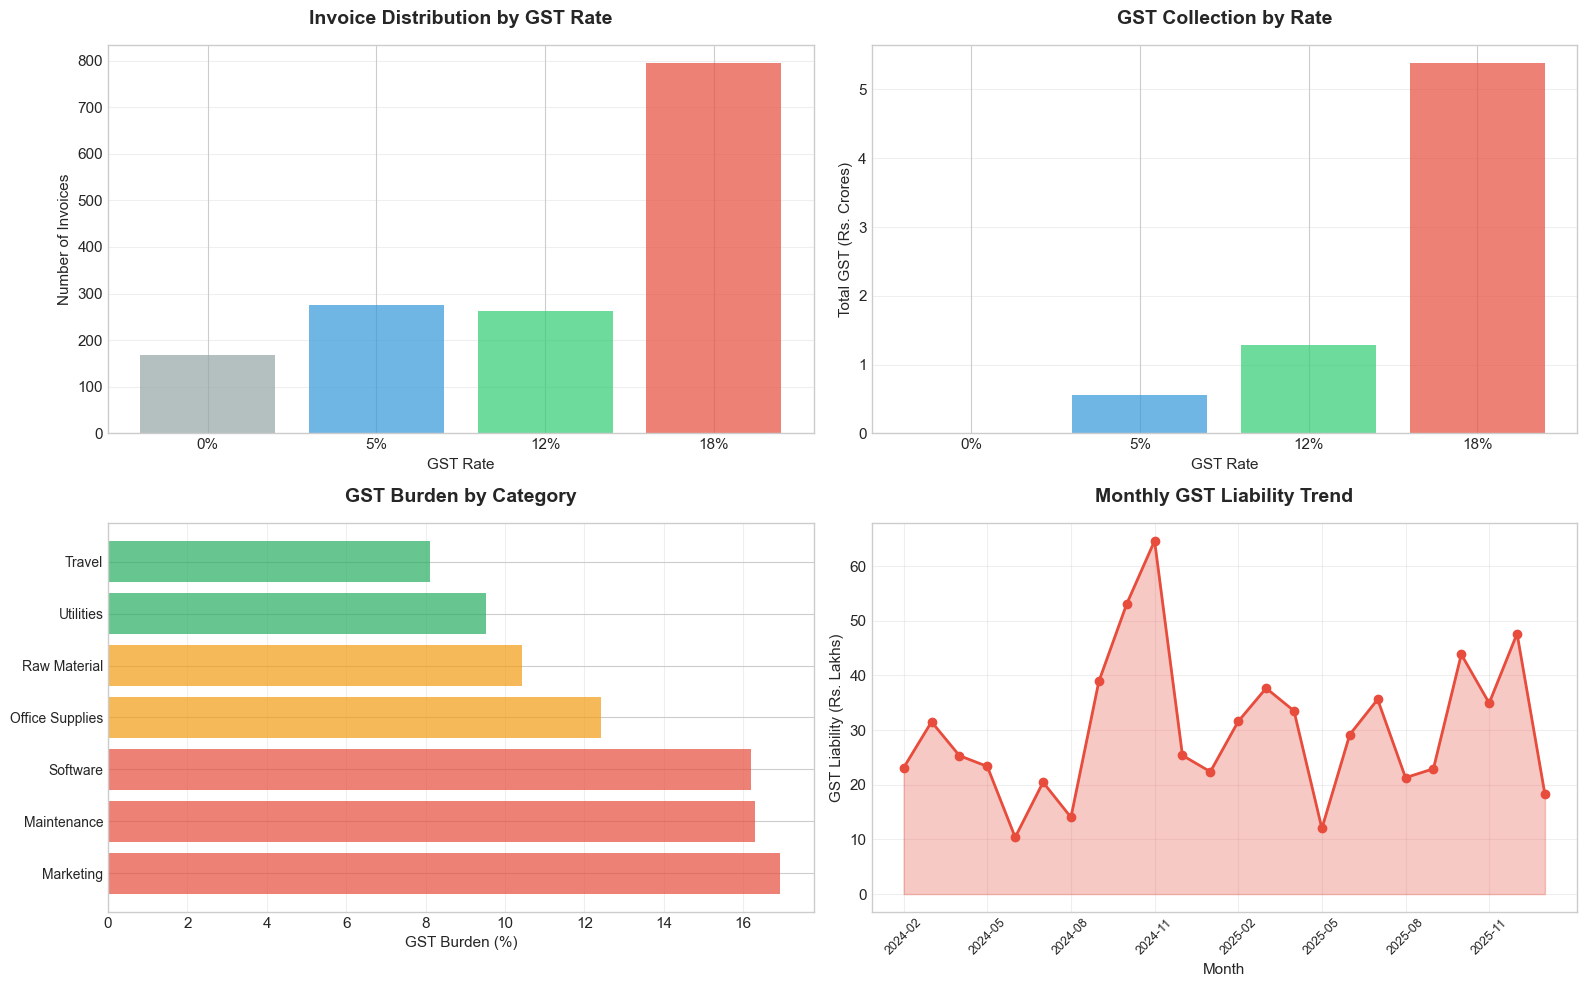


GST analysis complete


In [ ]:
"""
JUPYTER NOTEBOOK - CELL 9
GST Pattern and Compliance Analysis
"""

print("="*80)
print("GST PATTERN AND COMPLIANCE ANALYSIS")
print("="*80)

# GST Rate Distribution
print("\n" + "-"*80)
print("GST RATE DISTRIBUTION")
print("-"*80)

gst_distribution = df.groupby('gst_rate').agg({
    'invoice_id': 'count',
    'invoice_amount': 'sum',
    'gst_amount': 'sum'
}).round(2)

gst_distribution.columns = ['invoice_count', 'total_base_amount', 'total_gst']
gst_distribution['avg_gst_rate'] = (
    gst_distribution['total_gst'] / gst_distribution['total_base_amount'] * 100
).round(2)

print(gst_distribution)

# Most common GST rate
most_common_rate = gst_distribution['invoice_count'].idxmax()
print(f"\nMost common GST rate: {most_common_rate}% ({gst_distribution.loc[most_common_rate, 'invoice_count']:.0f} invoices)")

# Zero GST Analysis
print("\n" + "-"*80)
print("ZERO-GST TRANSACTION ANALYSIS")
print("-"*80)

zero_gst = df[df['gst_rate'] == 0]

if len(zero_gst) > 0:
    print(f"Total zero-GST invoices: {len(zero_gst)}")
    print(f"Percentage of total: {len(zero_gst)/len(df)*100:.1f}%")
    print(f"Total value: Rs. {zero_gst['invoice_amount'].sum():,.2f}")
    
    print("\nTop categories with 0% GST:")
    zero_gst_cat = zero_gst.groupby('expense_category')['invoice_amount'].agg(['sum', 'count'])
    zero_gst_cat = zero_gst_cat.sort_values('sum', ascending=False)
    print(zero_gst_cat)
    
    print("\nTop vendors with 0% GST:")
    zero_gst_vendor = zero_gst.groupby('vendor_name')['invoice_amount'].agg(['sum', 'count'])
    zero_gst_vendor = zero_gst_vendor.sort_values('sum', ascending=False).head(5)
    print(zero_gst_vendor)
    
    print("\n" + "-"*80)
    print("COMPLIANCE INSIGHT")
    print("-"*80)
    print("Zero-GST transactions may require:")
    print("  1. Reverse Charge Mechanism (RCM) assessment")
    print("  2. Export of services verification")
    print("  3. Exempted category confirmation")
    print("  4. GSTIN validation for domestic vendors")
else:
    print("No zero-GST transactions found")

# Category-wise GST Burden
print("\n" + "-"*80)
print("GST BURDEN BY CATEGORY")
print("-"*80)

category_gst = df.groupby('expense_category').agg({
    'invoice_amount': 'sum',
    'gst_amount': 'sum'
}).round(2)

category_gst['gst_burden_pct'] = (
    category_gst['gst_amount'] / category_gst['invoice_amount'] * 100
).round(2)

category_gst = category_gst.sort_values('gst_burden_pct', ascending=False)
print(category_gst)

# Identify GST-heavy vs GST-light categories
print("\nGST-Heavy Categories (>15% burden):")
gst_heavy = category_gst[category_gst['gst_burden_pct'] > 15]
for cat, row in gst_heavy.iterrows():
    print(f"  {cat}: {row['gst_burden_pct']:.1f}%")

print("\nGST-Light Categories (<10% burden):")
gst_light = category_gst[category_gst['gst_burden_pct'] < 10]
for cat, row in gst_light.iterrows():
    print(f"  {cat}: {row['gst_burden_pct']:.1f}%")

# Monthly GST Liability
print("\n" + "-"*80)
print("MONTHLY GST LIABILITY")
print("-"*80)

monthly_gst = df.groupby('invoice_month').agg({
    'gst_amount': 'sum',
    'invoice_amount': 'sum'
}).round(2)

monthly_gst['effective_gst_rate'] = (
    monthly_gst['gst_amount'] / monthly_gst['invoice_amount'] * 100
).round(2)

print(monthly_gst.tail(10))

avg_monthly_gst = monthly_gst['gst_amount'].mean()
print(f"\nAverage monthly GST liability: Rs. {avg_monthly_gst:,.2f}")
print(f"Total GST for period: Rs. {monthly_gst['gst_amount'].sum():,.2f}")

# Visualization
print("\n" + "-"*80)
print("GENERATING GST VISUALIZATIONS")
print("-"*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: GST Rate Distribution
ax1 = axes[0, 0]
rates = gst_distribution.index.astype(str) + '%'
counts = gst_distribution['invoice_count'].values
colors_gst = ['#95A5A6', '#3498DB', '#2ECC71', '#E74C3C']
ax1.bar(rates, counts, color=colors_gst, alpha=0.7)
ax1.set_xlabel('GST Rate', fontsize=11)
ax1.set_ylabel('Number of Invoices', fontsize=11)
ax1.set_title('Invoice Distribution by GST Rate', fontsize=14, fontweight='bold', pad=15)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: GST Amount by Rate
ax2 = axes[0, 1]
gst_amounts = gst_distribution['total_gst'].values / 10000000  # In crores
ax2.bar(rates, gst_amounts, color=colors_gst, alpha=0.7)
ax2.set_xlabel('GST Rate', fontsize=11)
ax2.set_ylabel('Total GST (Rs. Crores)', fontsize=11)
ax2.set_title('GST Collection by Rate', fontsize=14, fontweight='bold', pad=15)
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Category GST Burden
ax3 = axes[1, 0]
categories = category_gst.index
burden = category_gst['gst_burden_pct'].values
colors_burden = ['#27AE60' if x < 10 else '#F39C12' if x < 15 else '#E74C3C' for x in burden]
ax3.barh(range(len(categories)), burden, color=colors_burden, alpha=0.7)
ax3.set_yticks(range(len(categories)))
ax3.set_yticklabels(categories, fontsize=10)
ax3.set_xlabel('GST Burden (%)', fontsize=11)
ax3.set_title('GST Burden by Category', fontsize=14, fontweight='bold', pad=15)
ax3.grid(axis='x', alpha=0.3)

# Plot 4: Monthly GST Trend
ax4 = axes[1, 1]
monthly_gst_reset = monthly_gst.reset_index()
months_gst = monthly_gst_reset['invoice_month'].astype(str).values
gst_values = monthly_gst_reset['gst_amount'].values / 100000  # In lakhs
ax4.plot(range(len(months_gst)), gst_values, marker='o', linewidth=2, 
         markersize=6, color='#E74C3C')
ax4.fill_between(range(len(months_gst)), gst_values, alpha=0.3, color='#E74C3C')
ax4.set_xticks(range(0, len(months_gst), 3))
ax4.set_xticklabels(months_gst[::3], rotation=45, fontsize=9)
ax4.set_xlabel('Month', fontsize=11)
ax4.set_ylabel('GST Liability (Rs. Lakhs)', fontsize=11)
ax4.set_title('Monthly GST Liability Trend', fontsize=14, fontweight='bold', pad=15)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/gst_analysis_visualization.png', 
            dpi=300, bbox_inches='tight')
print("Saved: gst_analysis_visualization.png")
plt.show()

print("\nGST analysis complete")

In [ ]:
"""
JUPYTER NOTEBOOK - CELL 10
Vendor Segmentation - Feature Engineering
"""

print("="*80)
print("VENDOR SEGMENTATION - PART 1: FEATURE ENGINEERING")
print("="*80)

# Calculate vendor-level features
total_months = df['invoice_month'].nunique()
high_value_threshold = df['invoice_amount'].quantile(0.90)

print(f"\nDataset context:")
print(f"  Total months in dataset: {total_months}")
print(f"  High-value threshold (90th percentile): Rs. {high_value_threshold:,.2f}")

# Aggregate features by vendor
vendor_features = df.groupby('vendor_name').agg({
    'invoice_amount': ['sum', 'mean', 'std', 'count', 'min', 'max'],
    'invoice_month': 'nunique',
    'gst_rate': 'mean',
    'payment_mode': lambda x: (x == 'Credit').sum() / len(x) * 100,
    'total_amount': 'sum',
    'gst_amount': 'sum'
}).round(2)

# Flatten column names
vendor_features.columns = [
    'total_spend', 'avg_invoice', 'spend_volatility',
    'transaction_count', 'min_invoice', 'max_invoice',
    'months_active', 'avg_gst_rate', 'credit_ratio',
    'total_payable', 'total_gst'
]

print("\n" + "-"*80)
print("BASE FEATURES CREATED")
print("-"*80)
print(f"Total vendors: {len(vendor_features)}")
print(f"Base features: {len(vendor_features.columns)}")

# Derived features
print("\n" + "-"*80)
print("CREATING DERIVED FEATURES")
print("-"*80)

# 1. Monthly average spend
vendor_features['monthly_avg_spend'] = (
    vendor_features['total_spend'] / vendor_features['months_active']
).round(2)
print("[1/7] Created: monthly_avg_spend")

# 2. Consistency score (inverse of coefficient of variation)
cv = vendor_features['spend_volatility'] / vendor_features['avg_invoice']
vendor_features['consistency_score'] = (1 - cv.clip(upper=1)).round(2)
print("[2/7] Created: consistency_score")

# 3. Activity rate (percentage of months active)
vendor_features['activity_rate'] = (
    vendor_features['months_active'] / total_months * 100
).round(2)
print("[3/7] Created: activity_rate")

# 4. Invoice frequency (invoices per active month)
vendor_features['invoice_frequency'] = (
    vendor_features['transaction_count'] / vendor_features['months_active']
).round(2)
print("[4/7] Created: invoice_frequency")

# 5. Invoice value range
vendor_features['invoice_range'] = (
    vendor_features['max_invoice'] - vendor_features['min_invoice']
).round(2)
print("[5/7] Created: invoice_range")

# 6. High-value transaction ratio
high_value_counts = df[df['invoice_amount'] > high_value_threshold].groupby('vendor_name').size()
vendor_features['high_value_ratio'] = (
    high_value_counts / vendor_features['transaction_count'] * 100
).fillna(0).round(2)
print("[6/7] Created: high_value_ratio")

# 7. Average GST per invoice
vendor_features['avg_gst_per_invoice'] = (
    vendor_features['total_gst'] / vendor_features['transaction_count']
).round(2)
print("[7/7] Created: avg_gst_per_invoice")

print("\n" + "-"*80)
print("FEATURE ENGINEERING SUMMARY")
print("-"*80)
print(f"Total features created: {len(vendor_features.columns)}")
print(f"\nFeature list:")
for i, col in enumerate(vendor_features.columns, 1):
    print(f"  {i:2d}. {col}")

print("\n" + "-"*80)
print("FEATURE STATISTICS")
print("-"*80)
print(vendor_features[['monthly_avg_spend', 'consistency_score', 
                        'activity_rate', 'credit_ratio']].describe())

print("\n" + "-"*80)
print("SAMPLE VENDOR FEATURES (Top 5 by spend)")
print("-"*80)
print(vendor_features.nlargest(5, 'total_spend')[
    ['total_spend', 'monthly_avg_spend', 'consistency_score', 
     'activity_rate', 'credit_ratio']
])

print("\nFeature engineering complete")
print("Ready for clustering...")

VENDOR SEGMENTATION - PART 1: FEATURE ENGINEERING

Dataset context:
  Total months in dataset: 24
  High-value threshold (90th percentile): Rs. 885,749.37

--------------------------------------------------------------------------------
BASE FEATURES CREATED
--------------------------------------------------------------------------------
Total vendors: 27
Base features: 11

--------------------------------------------------------------------------------
CREATING DERIVED FEATURES
--------------------------------------------------------------------------------
[1/7] Created: monthly_avg_spend
[2/7] Created: consistency_score
[3/7] Created: activity_rate
[4/7] Created: invoice_frequency
[5/7] Created: invoice_range
[6/7] Created: high_value_ratio
[7/7] Created: avg_gst_per_invoice

--------------------------------------------------------------------------------
FEATURE ENGINEERING SUMMARY
--------------------------------------------------------------------------------
Total features creat

VENDOR SEGMENTATION - PART 2: K-MEANS CLUSTERING

--------------------------------------------------------------------------------
SELECTED FEATURES FOR CLUSTERING
--------------------------------------------------------------------------------
1. monthly_avg_spend
2. consistency_score
3. credit_ratio
4. activity_rate

Feature matrix shape: (27, 4)
Features standardized using StandardScaler
Scaled feature matrix shape: (27, 4)

--------------------------------------------------------------------------------
FINDING OPTIMAL NUMBER OF CLUSTERS
--------------------------------------------------------------------------------

Testing K values from 2 to 6...

K     Inertia         Silhouette Score    
----------------------------------------
2     76.86           0.3215              
3     57.47           0.3384              
4     38.82           0.3311              
5     25.17           0.3694              
6     20.42           0.3715              

Optimal K selected: 6
Best silhouette

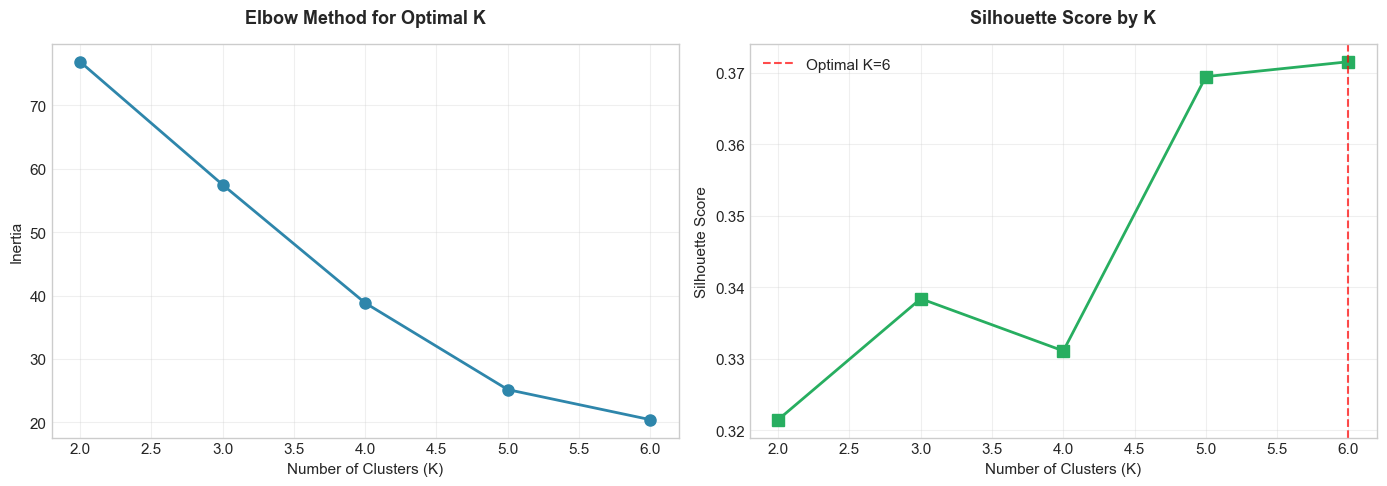


--------------------------------------------------------------------------------
PERFORMING K-MEANS CLUSTERING (K=6)
--------------------------------------------------------------------------------

Clustering complete:
  Number of clusters: 6
  Silhouette score: 0.3715
  Inertia: 20.42

--------------------------------------------------------------------------------
CLUSTER SIZE DISTRIBUTION
--------------------------------------------------------------------------------
Cluster 0: 10 vendors (37.0%)
Cluster 1: 5 vendors (18.5%)
Cluster 2: 4 vendors (14.8%)
Cluster 3: 1 vendors (3.7%)
Cluster 4: 5 vendors (18.5%)
Cluster 5: 2 vendors (7.4%)

Clustering complete


In [ ]:
"""
JUPYTER NOTEBOOK - CELL 11
Vendor Segmentation - Part 2: Clustering
"""

print("="*80)
print("VENDOR SEGMENTATION - PART 2: K-MEANS CLUSTERING")
print("="*80)

# Select features for clustering
clustering_features = [
    'monthly_avg_spend',    # Financial importance
    'consistency_score',    # Predictability
    'credit_ratio',         # Payment terms
    'activity_rate'         # Engagement level
]

print("\n" + "-"*80)
print("SELECTED FEATURES FOR CLUSTERING")
print("-"*80)
for i, feature in enumerate(clustering_features, 1):
    print(f"{i}. {feature}")

# Extract feature matrix
X = vendor_features[clustering_features].values
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

print(f"\nFeature matrix shape: {X.shape}")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features standardized using StandardScaler")
print(f"Scaled feature matrix shape: {X_scaled.shape}")

# Find optimal K using elbow method and silhouette score
print("\n" + "-"*80)
print("FINDING OPTIMAL NUMBER OF CLUSTERS")
print("-"*80)

inertias = []
silhouette_scores_list = []
k_values = range(2, 7)

print("\nTesting K values from 2 to 6...")
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores_list.append(silhouette_score(X_scaled, kmeans.labels_))

# Display results
print(f"\n{'K':<5} {'Inertia':<15} {'Silhouette Score':<20}")
print("-" * 40)
for k, inertia, sil_score in zip(k_values, inertias, silhouette_scores_list):
    print(f"{k:<5} {inertia:<15.2f} {sil_score:<20.4f}")

# Select optimal K
best_k_idx = np.argmax(silhouette_scores_list)
optimal_k = list(k_values)[best_k_idx]

print(f"\nOptimal K selected: {optimal_k}")
print(f"Best silhouette score: {silhouette_scores_list[best_k_idx]:.4f}")

# Visualization: Elbow curve and Silhouette scores
print("\n" + "-"*80)
print("GENERATING OPTIMIZATION VISUALIZATIONS")
print("-"*80)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Elbow curve
ax1.plot(k_values, inertias, marker='o', linewidth=2, markersize=8, color='#2E86AB')
ax1.set_xlabel('Number of Clusters (K)', fontsize=11)
ax1.set_ylabel('Inertia', fontsize=11)
ax1.set_title('Elbow Method for Optimal K', fontsize=13, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3)

# Silhouette scores
ax2.plot(k_values, silhouette_scores_list, marker='s', linewidth=2, 
         markersize=8, color='#27AE60')
ax2.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7,
            label=f'Optimal K={optimal_k}')
ax2.set_xlabel('Number of Clusters (K)', fontsize=11)
ax2.set_ylabel('Silhouette Score', fontsize=11)
ax2.set_title('Silhouette Score by K', fontsize=13, fontweight='bold', pad=15)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/clustering_optimization.png', 
            dpi=300, bbox_inches='tight')
print("Saved: clustering_optimization.png")
plt.show()

# Perform final clustering with optimal K
print("\n" + "-"*80)
print(f"PERFORMING K-MEANS CLUSTERING (K={optimal_k})")
print("-"*80)

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, max_iter=300)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Add cluster labels to vendor features
vendor_features['cluster'] = cluster_labels

# Calculate final metrics
final_silhouette = silhouette_score(X_scaled, cluster_labels)
final_inertia = kmeans_final.inertia_

print(f"\nClustering complete:")
print(f"  Number of clusters: {optimal_k}")
print(f"  Silhouette score: {final_silhouette:.4f}")
print(f"  Inertia: {final_inertia:.2f}")

# Cluster distribution
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print(f"\n" + "-"*80)
print("CLUSTER SIZE DISTRIBUTION")
print("-"*80)
for cluster_id, count in cluster_counts.items():
    pct = count / len(cluster_labels) * 100
    print(f"Cluster {cluster_id}: {count} vendors ({pct:.1f}%)")

print("\nClustering complete")

In [ ]:
"""
JUPYTER NOTEBOOK - CELL 12
Vendor Segmentation - Part 3: Cluster Interpretation
"""

print("="*80)
print("VENDOR SEGMENTATION - PART 3: CLUSTER INTERPRETATION")
print("="*80)

# Analyze each cluster
cluster_profiles = {}

for cluster_id in sorted(vendor_features['cluster'].unique()):
    cluster_vendors = vendor_features[vendor_features['cluster'] == cluster_id]
    
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id} ANALYSIS")
    print(f"Size: {len(cluster_vendors)} vendors ({len(cluster_vendors)/len(vendor_features)*100:.1f}%)")
    print("="*80)
    
    # Calculate cluster statistics
    profile = {
        'size': len(cluster_vendors),
        'avg_monthly_spend': cluster_vendors['monthly_avg_spend'].mean(),
        'avg_consistency': cluster_vendors['consistency_score'].mean(),
        'avg_credit_ratio': cluster_vendors['credit_ratio'].mean(),
        'avg_activity_rate': cluster_vendors['activity_rate'].mean(),
        'total_spend': cluster_vendors['total_spend'].sum()
    }
    
    print(f"\nCluster Characteristics:")
    print(f"  Average monthly spend: Rs. {profile['avg_monthly_spend']:,.2f}")
    print(f"  Consistency score: {profile['avg_consistency']:.2f}")
    print(f"  Credit payment ratio: {profile['avg_credit_ratio']:.1f}%")
    print(f"  Activity rate: {profile['avg_activity_rate']:.1f}%")
    print(f"  Total cluster spend: Rs. {profile['total_spend']:,.2f}")
    
    print(f"\nTop 5 Vendors:")
    top_vendors = cluster_vendors.nlargest(5, 'total_spend')
    for rank, (vendor, row) in enumerate(top_vendors.iterrows(), 1):
        print(f"  {rank}. {vendor}")
        print(f"     Spend: Rs. {row['total_spend']:,.2f} | " 
              f"Invoices: {row['transaction_count']:.0f} | "
              f"Active: {row['months_active']:.0f} months")
    
    cluster_profiles[cluster_id] = profile

# Assign business labels based on spending levels
print("\n" + "="*80)
print("ASSIGNING BUSINESS LABELS")
print("="*80)

# Sort clusters by average monthly spend
sorted_clusters = sorted(cluster_profiles.items(), 
                         key=lambda x: x[1]['avg_monthly_spend'], 
                         reverse=True)

# Assign labels
labels = {}
if len(sorted_clusters) >= 3:
    labels[sorted_clusters[0][0]] = "Strategic Partners"
    labels[sorted_clusters[1][0]] = "Operational Vendors"
    labels[sorted_clusters[2][0]] = "Tactical Vendors"
else:
    labels[sorted_clusters[0][0]] = "Strategic Partners"
    labels[sorted_clusters[1][0]] = "Tactical Vendors"

vendor_features['cluster_label'] = vendor_features['cluster'].map(labels)

print("\nCluster Labels Assigned:")
for cluster_id, label in labels.items():
    vendor_count = (vendor_features['cluster'] == cluster_id).sum()
    total_spend = cluster_profiles[cluster_id]['total_spend']
    print(f"  Cluster {cluster_id}: {label}")
    print(f"    Vendors: {vendor_count}")
    print(f"    Total spend: Rs. {total_spend:,.2f}")

# Detailed interpretation
print("\n" + "="*80)
print("CLUSTER BUSINESS INTERPRETATION")
print("="*80)

for cluster_id, label in labels.items():
    cluster_data = vendor_features[vendor_features['cluster'] == cluster_id]
    profile = cluster_profiles[cluster_id]
    
    print(f"\n{label.upper()}")
    print("-" * 80)
    
    if "Strategic" in label:
        print("Definition: High-value, consistent vendors with significant spend")
        print("Characteristics:")
        print(f"  - High monthly spend (avg Rs. {profile['avg_monthly_spend']:,.2f})")
        print(f"  - Consistent spending patterns (score: {profile['avg_consistency']:.2f})")
        print(f"  - Often use credit terms ({profile['avg_credit_ratio']:.1f}%)")
        print("Business Recommendations:")
        print("  1. Negotiate volume discounts based on annual spend")
        print("  2. Set up automated monthly payment cycles")
        print("  3. Conduct quarterly business reviews")
        print("  4. Prioritize these vendors for better payment terms")
        
    elif "Operational" in label:
        print("Definition: Moderate-spend, regular vendors for routine operations")
        print("Characteristics:")
        print(f"  - Moderate monthly spend (avg Rs. {profile['avg_monthly_spend']:,.2f})")
        print(f"  - Regular transaction frequency")
        print(f"  - Stable activity rate ({profile['avg_activity_rate']:.1f}%)")
        print("Business Recommendations:")
        print("  1. Automate invoice approval for routine purchases")
        print("  2. Standard NET-30 payment terms")
        print("  3. Monitor for cost optimization opportunities")
        print("  4. Track spending trends monthly")
        
    else:  # Tactical
        print("Definition: Low-spend, irregular vendors for ad-hoc needs")
        print("Characteristics:")
        print(f"  - Low monthly spend (avg Rs. {profile['avg_monthly_spend']:,.2f})")
        print(f"  - Irregular transaction patterns")
        print(f"  - Low activity rate ({profile['avg_activity_rate']:.1f}%)")
        print("Business Recommendations:")
        print("  1. Enable quick approval for small invoices (<Rs. 50,000)")
        print("  2. Review vendor consolidation opportunities")
        print("  3. Instant payment for invoices <Rs. 25,000")
        print("  4. Minimal documentation requirements")

print("\n" + "="*80)
print("CLUSTER COMPARISON TABLE")
print("="*80)

comparison = pd.DataFrame({
    label: {
        'Vendor Count': cluster_profiles[cluster_id]['size'],
        'Avg Monthly Spend': f"Rs. {cluster_profiles[cluster_id]['avg_monthly_spend']:,.0f}",
        'Consistency': f"{cluster_profiles[cluster_id]['avg_consistency']:.2f}",
        'Credit Usage': f"{cluster_profiles[cluster_id]['avg_credit_ratio']:.1f}%",
        'Activity Rate': f"{cluster_profiles[cluster_id]['avg_activity_rate']:.1f}%",
        'Total Spend': f"Rs. {cluster_profiles[cluster_id]['total_spend']:,.0f}"
    }
    for cluster_id, label in labels.items()
}).T

print(comparison)

print("\nCluster interpretation complete")

VENDOR SEGMENTATION - PART 3: CLUSTER INTERPRETATION

CLUSTER 0 ANALYSIS
Size: 10 vendors (37.0%)

Cluster Characteristics:
  Average monthly spend: Rs. 498,226.03
  Consistency score: 0.47
  Credit payment ratio: 7.2%
  Activity rate: 85.4%
  Total cluster spend: Rs. 113,606,773.92

Top 5 Vendors:
  1. Reliance Industrial Supplies
     Spend: Rs. 54,453,980.56 | Invoices: 133 | Active: 24 months
  2. Amazon Web Services India
     Spend: Rs. 12,989,229.85 | Invoices: 79 | Active: 24 months
  3. Mahindra Logistics Ltd
     Spend: Rs. 12,031,131.17 | Invoices: 100 | Active: 23 months
  4. Google Cloud India
     Spend: Rs. 9,938,403.11 | Invoices: 63 | Active: 22 months
  5. BPCL Fuel Services
     Spend: Rs. 8,562,809.47 | Invoices: 70 | Active: 24 months

CLUSTER 1 ANALYSIS
Size: 5 vendors (18.5%)

Cluster Characteristics:
  Average monthly spend: Rs. 38,940.30
  Consistency score: 0.45
  Credit payment ratio: 12.7%
  Activity rate: 36.7%
  Total cluster spend: Rs. 1,829,983.46

Top 5

VENDOR SEGMENTATION - PART 4: CLUSTER VISUALIZATIONS

Saved: vendor_segmentation_visualization.png


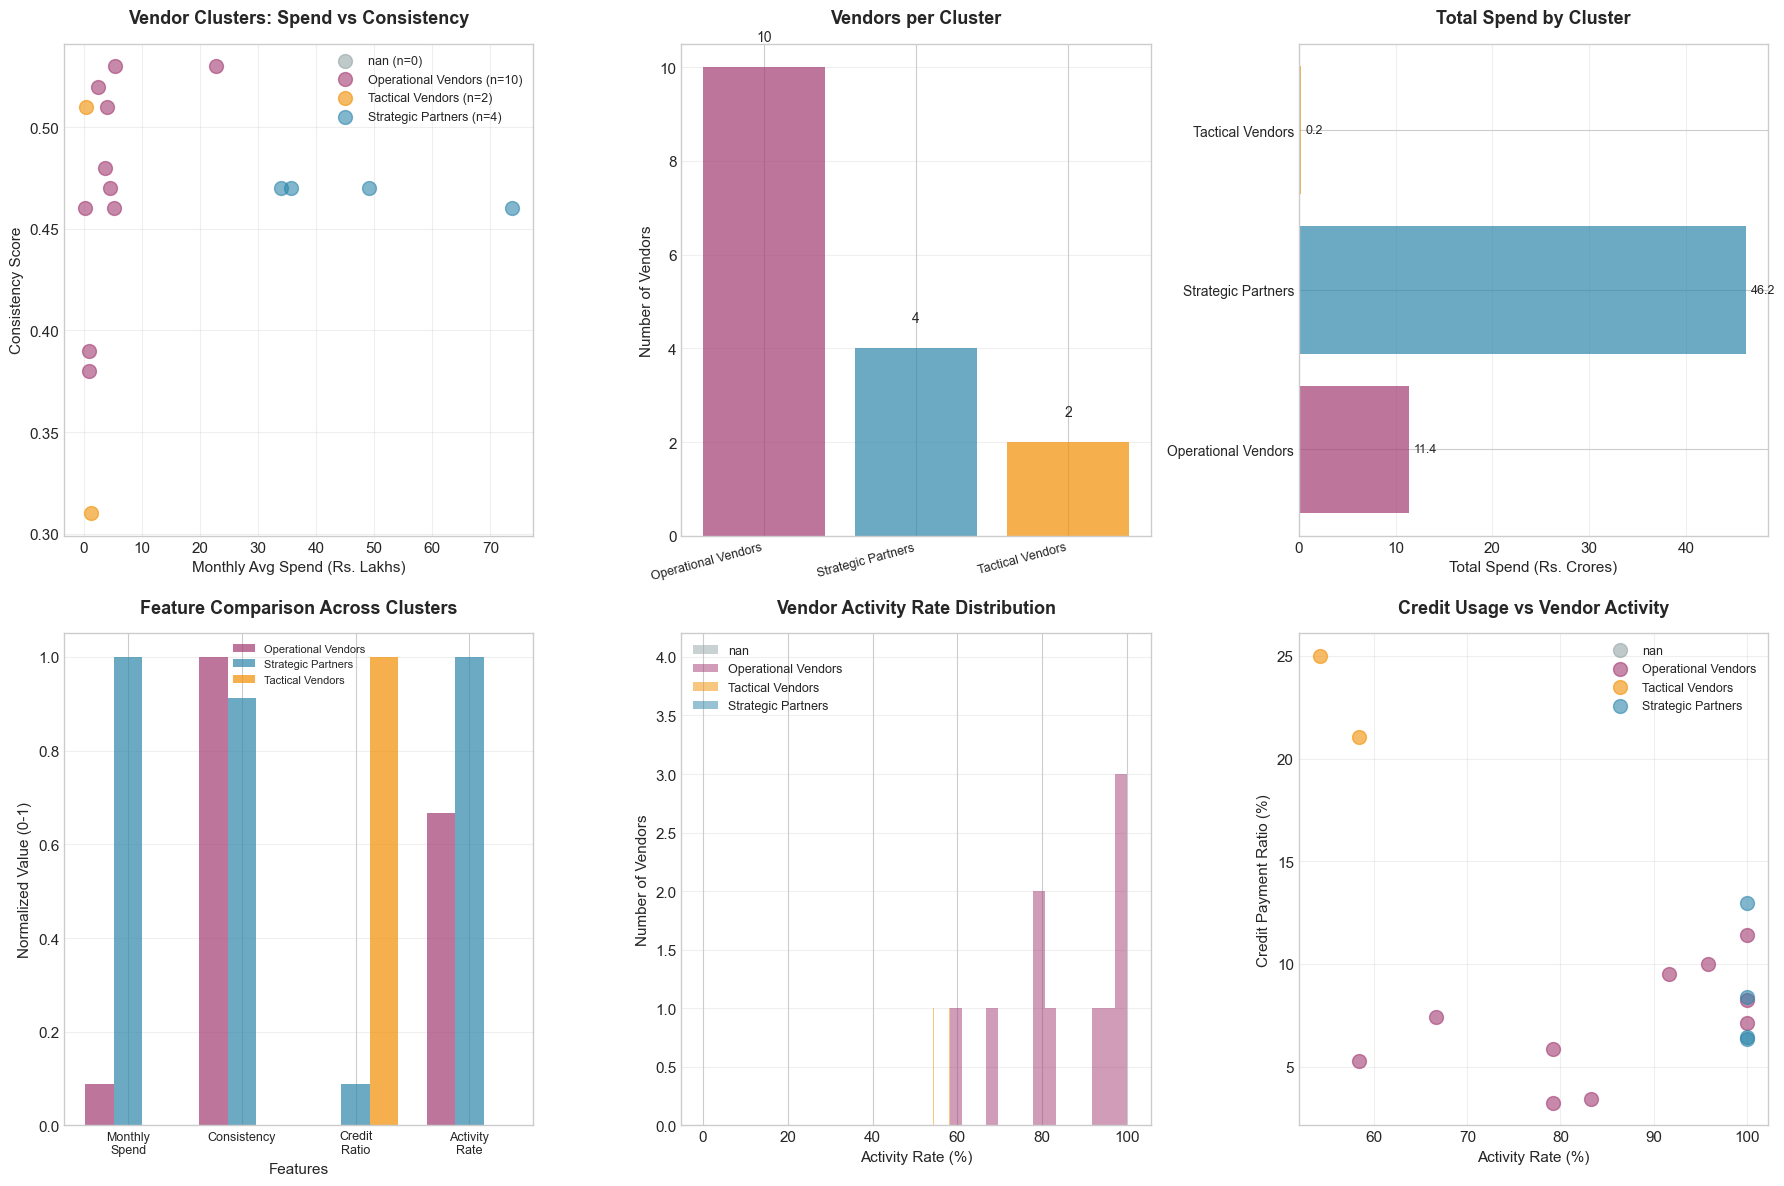


Cluster visualization complete


In [ ]:
"""
JUPYTER NOTEBOOK - CELL 13
Vendor Segmentation - Part 4: Cluster Visualization
"""

print("="*80)
print("VENDOR SEGMENTATION - PART 4: CLUSTER VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Color scheme for clusters
cluster_colors = {
    'Strategic Partners': '#2E86AB',
    'Operational Vendors': '#A23B72',
    'Tactical Vendors': '#F18F01'
}

# Plot 1: 2D Scatter (Monthly Spend vs Consistency)
ax1 = axes[0, 0]
for label in vendor_features['cluster_label'].unique():
    cluster_data = vendor_features[vendor_features['cluster_label'] == label]
    ax1.scatter(
        cluster_data['monthly_avg_spend'] / 100000,  # In lakhs
        cluster_data['consistency_score'],
        label=f'{label} (n={len(cluster_data)})',
        s=100,
        alpha=0.6,
        color=cluster_colors.get(label, '#95A5A6')
    )

ax1.set_xlabel('Monthly Avg Spend (Rs. Lakhs)', fontsize=11)
ax1.set_ylabel('Consistency Score', fontsize=11)
ax1.set_title('Vendor Clusters: Spend vs Consistency', fontsize=13, fontweight='bold', pad=15)
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Plot 2: Cluster Size Distribution
ax2 = axes[0, 1]
cluster_sizes = vendor_features['cluster_label'].value_counts()
colors_list = [cluster_colors.get(label, '#95A5A6') for label in cluster_sizes.index]

ax2.bar(range(len(cluster_sizes)), cluster_sizes.values, color=colors_list, alpha=0.7)
ax2.set_xticks(range(len(cluster_sizes)))
ax2.set_xticklabels(cluster_sizes.index, rotation=15, ha='right', fontsize=9)
ax2.set_ylabel('Number of Vendors', fontsize=11)
ax2.set_title('Vendors per Cluster', fontsize=13, fontweight='bold', pad=15)
ax2.grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, v in enumerate(cluster_sizes.values):
    ax2.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=10)

# Plot 3: Total Spend by Cluster
ax3 = axes[0, 2]
cluster_spend = vendor_features.groupby('cluster_label')['total_spend'].sum() / 10000000  # In crores
colors_list = [cluster_colors.get(label, '#95A5A6') for label in cluster_spend.index]

ax3.barh(range(len(cluster_spend)), cluster_spend.values, color=colors_list, alpha=0.7)
ax3.set_yticks(range(len(cluster_spend)))
ax3.set_yticklabels(cluster_spend.index, fontsize=10)
ax3.set_xlabel('Total Spend (Rs. Crores)', fontsize=11)
ax3.set_title('Total Spend by Cluster', fontsize=13, fontweight='bold', pad=15)
ax3.grid(axis='x', alpha=0.3)

# Add spend labels
for i, v in enumerate(cluster_spend.values):
    ax3.text(v + 0.5, i, f'{v:.1f}', ha='left', va='center', fontsize=9)

# Plot 4: Feature Comparison Across Clusters
ax4 = axes[1, 0]
features_to_compare = ['monthly_avg_spend', 'consistency_score', 
                       'credit_ratio', 'activity_rate']

# Normalize features for comparison
cluster_means = vendor_features.groupby('cluster_label')[features_to_compare].mean()
cluster_means_normalized = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())

x = np.arange(len(features_to_compare))
width = 0.25

for i, (label, row) in enumerate(cluster_means_normalized.iterrows()):
    ax4.bar(x + i*width, row.values, width, 
            label=label, color=cluster_colors.get(label, '#95A5A6'), alpha=0.7)

ax4.set_xlabel('Features', fontsize=11)
ax4.set_ylabel('Normalized Value (0-1)', fontsize=11)
ax4.set_title('Feature Comparison Across Clusters', fontsize=13, fontweight='bold', pad=15)
ax4.set_xticks(x + width)
ax4.set_xticklabels(['Monthly\nSpend', 'Consistency', 'Credit\nRatio', 'Activity\nRate'], 
                    fontsize=9)
ax4.legend(fontsize=8)
ax4.grid(axis='y', alpha=0.3)

# Plot 5: Activity Rate Distribution
ax5 = axes[1, 1]
for label in vendor_features['cluster_label'].unique():
    cluster_data = vendor_features[vendor_features['cluster_label'] == label]
    ax5.hist(cluster_data['activity_rate'], bins=15, alpha=0.5, 
            label=label, color=cluster_colors.get(label, '#95A5A6'))

ax5.set_xlabel('Activity Rate (%)', fontsize=11)
ax5.set_ylabel('Number of Vendors', fontsize=11)
ax5.set_title('Vendor Activity Rate Distribution', fontsize=13, fontweight='bold', pad=15)
ax5.legend(fontsize=9)
ax5.grid(axis='y', alpha=0.3)

# Plot 6: Credit Usage vs Activity
ax6 = axes[1, 2]
for label in vendor_features['cluster_label'].unique():
    cluster_data = vendor_features[vendor_features['cluster_label'] == label]
    ax6.scatter(
        cluster_data['activity_rate'],
        cluster_data['credit_ratio'],
        label=label,
        s=100,
        alpha=0.6,
        color=cluster_colors.get(label, '#95A5A6')
    )

ax6.set_xlabel('Activity Rate (%)', fontsize=11)
ax6.set_ylabel('Credit Payment Ratio (%)', fontsize=11)
ax6.set_title('Credit Usage vs Vendor Activity', fontsize=13, fontweight='bold', pad=15)
ax6.legend(fontsize=9)
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/vendor_segmentation_visualization.png', 
            dpi=300, bbox_inches='tight')
print("\nSaved: vendor_segmentation_visualization.png")
plt.show()

print("\nCluster visualization complete")

In [ ]:
"""
JUPYTER NOTEBOOK - CELL 14
Final Summary and Data Export
"""

print("="*80)
print("FINAL ANALYSIS SUMMARY")
print("="*80)

# Dataset Overview
print("\n" + "-"*80)
print("DATASET OVERVIEW")
print("-"*80)

total_spend = df['invoice_amount'].sum()
total_gst = df['gst_amount'].sum()
total_invoices = len(df)
unique_vendors = df['vendor_name'].nunique()
unique_categories = df['expense_category'].nunique()
date_range_days = (df['invoice_date'].max() - df['invoice_date'].min()).days

print(f"Total Invoices: {total_invoices:,}")
print(f"Analysis Period: {date_range_days} days ({date_range_days/30:.1f} months)")
print(f"Date Range: {df['invoice_date'].min().date()} to {df['invoice_date'].max().date()}")
print(f"Unique Vendors: {unique_vendors}")
print(f"Expense Categories: {unique_categories}")
print(f"Total Spend (GST-exclusive): Rs. {total_spend:,.2f}")
print(f"Total GST: Rs. {total_gst:,.2f}")
print(f"Total Payable: Rs. {(total_spend + total_gst):,.2f}")
print(f"Average Invoice Value: Rs. {total_spend/total_invoices:,.2f}")

# Key Insights
print("\n" + "-"*80)
print("KEY INSIGHTS")
print("-"*80)

# Insight 1: Top Expense Category
top_category = category_analysis.index[0]
top_category_spend = category_analysis.iloc[0]['total_spend']
top_category_pct = category_analysis.iloc[0]['pct_of_total']

print(f"\n1. DOMINANT EXPENSE CATEGORY")
print(f"   {top_category} accounts for {top_category_pct:.1f}% of total spend")
print(f"   Total: Rs. {top_category_spend:,.2f}")
print(f"   Volatility: {category_analysis.iloc[0]['volatility_type']}")

# Insight 2: Vendor Concentration
top3_vendor_spend = vendor_analysis.head(3)['total_spend'].sum()
vendor_concentration = (top3_vendor_spend / total_spend * 100)

print(f"\n2. VENDOR CONCENTRATION RISK")
print(f"   Top 3 vendors: {vendor_concentration:.1f}% of total spend")
print(f"   Risk level: {'HIGH' if vendor_concentration > 50 else 'MODERATE' if vendor_concentration > 30 else 'LOW'}")
if vendor_concentration > 50:
    print(f"   Recommendation: Consider diversifying vendor base")

# Insight 3: Zero GST Analysis
zero_gst_count = len(df[df['gst_rate'] == 0])
zero_gst_value = df[df['gst_rate'] == 0]['invoice_amount'].sum()

print(f"\n3. GST COMPLIANCE OPPORTUNITY")
print(f"   Zero-GST invoices: {zero_gst_count} ({zero_gst_count/total_invoices*100:.1f}%)")
print(f"   Total value: Rs. {zero_gst_value:,.2f}")
print(f"   Action required: Verify RCM applicability for software vendors")

# Insight 4: Monthly Volatility
avg_mom_change = monthly_trends['mom_growth_pct'].abs().mean()

print(f"\n4. SPENDING VOLATILITY")
print(f"   Average MoM change: {avg_mom_change:.1f}%")
print(f"   Stability: {'STABLE' if avg_mom_change < 10 else 'MODERATE' if avg_mom_change < 20 else 'VOLATILE'}")

# Insight 5: Vendor Segmentation
print(f"\n5. VENDOR SEGMENTATION RESULTS")
for label in sorted(vendor_features['cluster_label'].unique()):
    cluster_vendors = vendor_features[vendor_features['cluster_label'] == label]
    cluster_spend = cluster_vendors['total_spend'].sum()
    print(f"   {label}: {len(cluster_vendors)} vendors (Rs. {cluster_spend:,.2f})")

# Data Quality Summary
print("\n" + "-"*80)
print("DATA QUALITY IMPROVEMENTS")
print("-"*80)

print(f"Categories standardized: {df_original['expense_category'].nunique()} → {df['expense_category'].nunique()}")
print(f"GST amounts imputed: {df['gst_amount_imputed'].sum()} records")
print(f"GST calculation errors flagged: {df['gst_error_flag'].sum()} records")
print(f"Dates parsed successfully: {len(df) - df['invoice_date'].isnull().sum()}/{len(df)}")

# Export Data
print("\n" + "-"*80)
print("EXPORTING ANALYSIS RESULTS")
print("-"*80)

# 1. Cleaned dataset
output_path_cleaned = 'outputs/cleaned_invoices.csv'
df.to_csv(output_path_cleaned, index=False)
print(f"[1/5] Saved: cleaned_invoices.csv ({len(df)} rows, {len(df.columns)} columns)")

# 2. Monthly trends
output_path_monthly = 'outputs/monthly_trends.csv'
monthly_trends.to_csv(output_path_monthly, index=False)
print(f"[2/5] Saved: monthly_trends.csv ({len(monthly_trends)} rows)")

# 3. Category analysis
output_path_category = 'outputs/category_analysis.csv'
category_analysis.to_csv(output_path_category)
print(f"[3/5] Saved: category_analysis.csv ({len(category_analysis)} categories)")

# 4. Vendor analysis
output_path_vendor = 'outputs/vendor_analysis.csv'
vendor_analysis.to_csv(output_path_vendor)
print(f"[4/5] Saved: vendor_analysis.csv ({len(vendor_analysis)} vendors)")

# 5. Vendor clusters
output_path_clusters = 'outputs/vendor_clusters.csv'
vendor_features.to_csv(output_path_clusters)
print(f"[5/5] Saved: vendor_clusters.csv ({len(vendor_features)} vendors)")

# Summary Report
print("\n" + "-"*80)
print("GENERATED VISUALIZATIONS")
print("-"*80)
print("[1/5] monthly_trends_visualization.png")
print("[2/5] category_analysis_visualization.png")
print("[3/5] vendor_analysis_visualization.png")
print("[4/5] gst_analysis_visualization.png")
print("[5/5] vendor_segmentation_visualization.png")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print("\nAll outputs saved to: outputs/")
print("\nSummary:")
print(f"  - {total_invoices:,} invoices analyzed")
print(f"  - {unique_vendors} vendors segmented")
print(f"  - {unique_categories} expense categories standardized")
print(f"  - Rs. {total_spend:,.2f} in total spend")
print(f"  - {zero_gst_count} compliance opportunities identified")
print("\nNext Steps:")
print("  1. Review visualizations for presentation")
print("  2. Share insights with finance team")
print("  3. Implement recommended vendor strategies")
print("  4. Set up automated monthly analysis")

print("\n" + "="*80)

FINAL ANALYSIS SUMMARY

--------------------------------------------------------------------------------
DATASET OVERVIEW
--------------------------------------------------------------------------------
Total Invoices: 1,500
Analysis Period: 729 days (24.3 months)
Date Range: 2024-02-01 to 2026-01-30
Unique Vendors: 27
Expense Categories: 7
Total Spend (GST-exclusive): Rs. 580,887,437.97
Total GST: Rs. 72,129,334.76
Total Payable: Rs. 653,016,772.73
Average Invoice Value: Rs. 387,258.29

--------------------------------------------------------------------------------
KEY INSIGHTS
--------------------------------------------------------------------------------

1. DOMINANT EXPENSE CATEGORY
   Raw Material accounts for 60.1% of total spend
   Total: Rs. 349,193,432.77
   Volatility: Volatile

2. VENDOR CONCENTRATION RISK
   Top 3 vendors: 65.5% of total spend
   Risk level: HIGH
   Recommendation: Consider diversifying vendor base

3. GST COMPLIANCE OPPORTUNITY
   Zero-GST invoices: 168 

TypeError: '<' not supported between instances of 'str' and 'float'